In [1]:
# import
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# logfile to be processed
logfile = "testlog.log"

In [3]:
# create simplified logfile containing only actual time series
simplified_log = open(logfile[:-4] + "_simplified_log.txt", "w")

with open(logfile, "r") as f:
    for line in f:
        line_splitted = line.split(";")
        if line_splitted[0] == "# Telemetie\n":
            continue
        elif int(line_splitted[0]) > 0:
            line_merged = ";".join(line_splitted)
            simplified_log.write(line_merged)

simplified_log.close()

In [4]:
# sensors dataframe: sensor_id, sensor_name, signal_id, signal_name, signal_unit
superlist = []
sensor_id = []

with open(logfile, "r") as f:
    for line in f:
        line_splitted = line.split(";")
        if (line_splitted[0] == "000000000") and (line_splitted[2] == "0") and (line_splitted[1] not in sensor_id):
            dikt = {
                "sensor_id": line_splitted[1],
                "sensor_name": line_splitted[3]
            }
            sensor_id.append(line_splitted[1])
            superlist.append(dikt)
            
helper_df = pd.DataFrame(superlist)

superlist = []

with open(logfile, "r") as f:
    for line in f:
        line_splitted = line.split(";")
        if line_splitted[0] == "000000000" and line_splitted[2] != "0":
            
            sensor_id = line_splitted[1]
            sensor_name = helper_df.loc[helper_df["sensor_id"] == sensor_id, "sensor_name"].to_numpy()[0]
            signal_id = line_splitted[2]
            signal_name = line_splitted[3]
            signal_unit = "n/a" if line_splitted[4].strip() == "" else line_splitted[4].strip()
                
            dikt = {
                    "sensor_id": sensor_id,
                    "sensor_name": sensor_name,
                    "signal_id": signal_id,
                    "signal_name": signal_name,
                    "signal_unit": signal_unit
            }
            superlist.append(dikt)
            
sensor_df = pd.DataFrame(superlist)
sensor_df.to_excel(os.path.join(logfile[:-4] + "_sensors.xlsx"))
sensor_df

,sensor_id,sensor_name,signal_id,signal_name,signal_unit
0,4385721145,Rx REX3,1,U Rx,V
1,4385721145,Rx REX3,2,A1,n/a
2,4385721145,Rx REX3,3,A2,n/a
3,4385721145,Rx REX3,4,Q,%
4,4199312898,IG_Testsensor,1,001,n/a
5,4199312898,IG_Testsensor,2,002,n/a
6,4199312898,IG_Testsensor,3,003,n/a
7,4199312898,IG_Testsensor,4,004,n/a
8,4199312898,IG_Testsensor,5,005,n/a
9,4199312898,IG_Testsensor,6,006,n/a


In [5]:
# create diff_df containing time series data of all signals from all registered sensors including diff_times & label
superlist = []

with open(logfile[:-4] + "_simplified_log.txt", "r") as f:
    for line in f:
        intermediate = []
        final = []
        
        line = line.strip()
        line_splitted = line.split(";")
        line_rear_splitted = line_splitted[2:]

        for i in range(0, len(line_rear_splitted), 4):
            temp = ";".join(line_rear_splitted[i:i+4])
            intermediate.append(temp)
        
        for element in intermediate:
            temp = element.split(";")
            final.append(temp)
        
        for element in final:
            
            time = line_splitted[0]
            sensor_id = line_splitted[1]
            
            if sensor_id in list(sensor_df["sensor_id"]):
                sensor_name = list(sensor_df.loc[sensor_df["sensor_id"] == sensor_id]["sensor_name"])[0]
            else:
                sensor_name = "n/a"
            
            signal_id = element[0]
            signal_name = sensor_df[(sensor_df["sensor_id"] == sensor_id) & (sensor_df["signal_id"] == signal_id)].iloc[0]["signal_name"]
            signal_value = element[3]
            
            dikt = {
                "time": int(time),
                "sensor_id": int(sensor_id),
                "sensor_name": str(sensor_name),
                "signal_id": int(signal_id),
                "signal_name": str(signal_name),
                "signal_value": float(signal_value)
            }

            superlist.append(dikt)

data_df = pd.DataFrame(superlist)

superlist = []

for (sensor_id, signal_id), group_data in data_df.groupby(["sensor_id", "signal_id"]):
    time_diff = np.array(group_data["time"].diff().dropna())
    dikt = {
        "time": np.array(group_data["time"].iloc[1:]),
        "time_diff": time_diff,
        "sensor_id": np.array(group_data["sensor_id"].iloc[1:]),
        "sensor_name": np.array(group_data["sensor_name"].iloc[1:]),
        "signal_id": np.array(group_data["signal_id"].iloc[1:]),
        "signal_name": np.array(group_data["signal_name"].iloc[1:]),
        "signal_value": np.array(group_data["signal_value"].iloc[1:])
        }
    superlist.append(pd.DataFrame(dikt))
    
diff_df = pd.concat(superlist, ignore_index = True)
diff_df["label"] = [f'{row["sensor_name"]}_{row["signal_name"]}' for _, row in diff_df.iterrows()]
diff_df.to_excel(os.path.join(logfile[:-4] + "_data.xlsx"))
diff_df

,time,time_diff,sensor_id,sensor_name,signal_id,signal_name,signal_value,label
0,257710,786.0,4199312898,IG_Testsensor,1,001,1.0,IG_Testsensor_001
1,258462,752.0,4199312898,IG_Testsensor,1,001,1.0,IG_Testsensor_001
2,259216,754.0,4199312898,IG_Testsensor,1,001,1.0,IG_Testsensor_001
3,259961,745.0,4199312898,IG_Testsensor,1,001,1.0,IG_Testsensor_001
4,260722,761.0,4199312898,IG_Testsensor,1,001,1.0,IG_Testsensor_001
...,...,...,...,...,...,...,...,...
4892,382425,1000.0,4385721145,Rx REX3,103,InputPin3,0.0,Rx REX3_InputPin3
4893,383446,1021.0,4385721145,Rx REX3,103,InputPin3,0.0,Rx REX3_InputPin3
4894,384467,1021.0,4385721145,Rx REX3,103,InputPin3,0.0,Rx REX3_InputPin3
4895,385487,1020.0,4385721145,Rx REX3,103,InputPin3,0.0,Rx REX3_InputPin3


In [6]:
# stats
stats_df = diff_df.groupby(["sensor_name", "signal_name"]).describe()["time_diff"]
stats_df.to_excel(os.path.join(logfile[:-4] + "_stats.xlsx"))
stats_df

count         mean         std    min      25%  \
sensor_name   signal_name                                                   
IG_Testsensor 001          157.0   825.006369  211.666601  719.0   741.00   
              002          157.0   825.006369  211.666601  719.0   741.00   
              003          157.0   825.006369  211.666601  719.0   741.00   
              004          157.0   825.891720  215.592849  722.0   742.00   
              005          157.0   825.891720  215.592849  722.0   742.00   
              006          157.0   825.891720  215.592849  722.0   742.00   
              007          157.0   825.891720  215.592849  722.0   742.00   
              008          157.0   825.891720  215.592849  722.0   742.00   
              009          157.0   826.910828  218.251366  733.0   741.00   
              010          157.0   826.910828  218.251366  733.0   741.00   
              011          157.0   826.910828  218.251366  733.0   741.00   
              012          157.0   826.910828  218.251366  733.0   741.00   
              013          157.0   826.910828  218.251366  733.0   741.00   
              014          158.0   822.689873  221.702558  186.0   741.25   
              015          158.0   822.689873  221.702558  186.0   741.25   
              016          158.0   822.689873  221.702558  186.0   741.25   
              017          158.0   822.689873  221.702558  186.0   741.25   
              018          158.0   822.689873  221.702558  186.0   741.25   
              019          157.0   828.834395  220.370226  486.0   742.00   
              020          157.0   828.834395  220.370226  486.0   742.00   
              021          157.0   828.834395  220.370226  486.0   742.00   
              022          157.0   828.834395  220.370226  486.0   742.00   
              023          157.0   825.006369  211.667207  719.0   741.00   
              024          157.0   825.006369  211.667207  719.0   741.00   
Rx REX3       A1           249.0   520.076305    7.231079  461.0   520.00   
              A2           249.0   520.076305    7.231079  461.0   520.00   
              InputPin3    128.0  1012.226562   15.997645  890.0  1002.00   
              Q            249.0   520.076305    7.231079  461.0   520.00   
              U Rx         249.0   520.076305    7.231079  461.0   520.00   

                              50%     75%     max  
sensor_name   signal_name                          
IG_Testsensor 001           760.0   762.0  1524.0  
              002           760.0   762.0  1524.0  
              003           760.0   762.0  1524.0  
              004           760.0   762.0  1525.0  
              005           760.0   762.0  1525.0  
              006           760.0   762.0  1525.0  
              007           760.0   762.0  1525.0  
              008           760.0   762.0  1525.0  
              009           760.0   761.0  1521.0  
              010           760.0   761.0  1521.0  
              011           760.0   761.0  1521.0  
              012           760.0   761.0  1521.0  
              013           760.0   761.0  1521.0  
              014           760.0   761.0  1522.0  
              015           760.0   761.0  1522.0  
              016           760.0   761.0  1522.0  
              017           760.0   761.0  1522.0  
              018           760.0   761.0  1522.0  
              019           760.0   762.0  1522.0  
              020           760.0   762.0  1522.0  
              021           760.0   762.0  1522.0  
              022           760.0   762.0  1522.0  
              023           760.0   762.0  1524.0  
              024           760.0   762.0  1524.0  
Rx REX3       A1            521.0   521.0   592.0  
              A2            521.0   521.0   592.0  
              InputPin3    1020.0  1021.0  1042.0  
              Q             521.0   521.0   592.0  
              U Rx          521.0   521.0   592.0

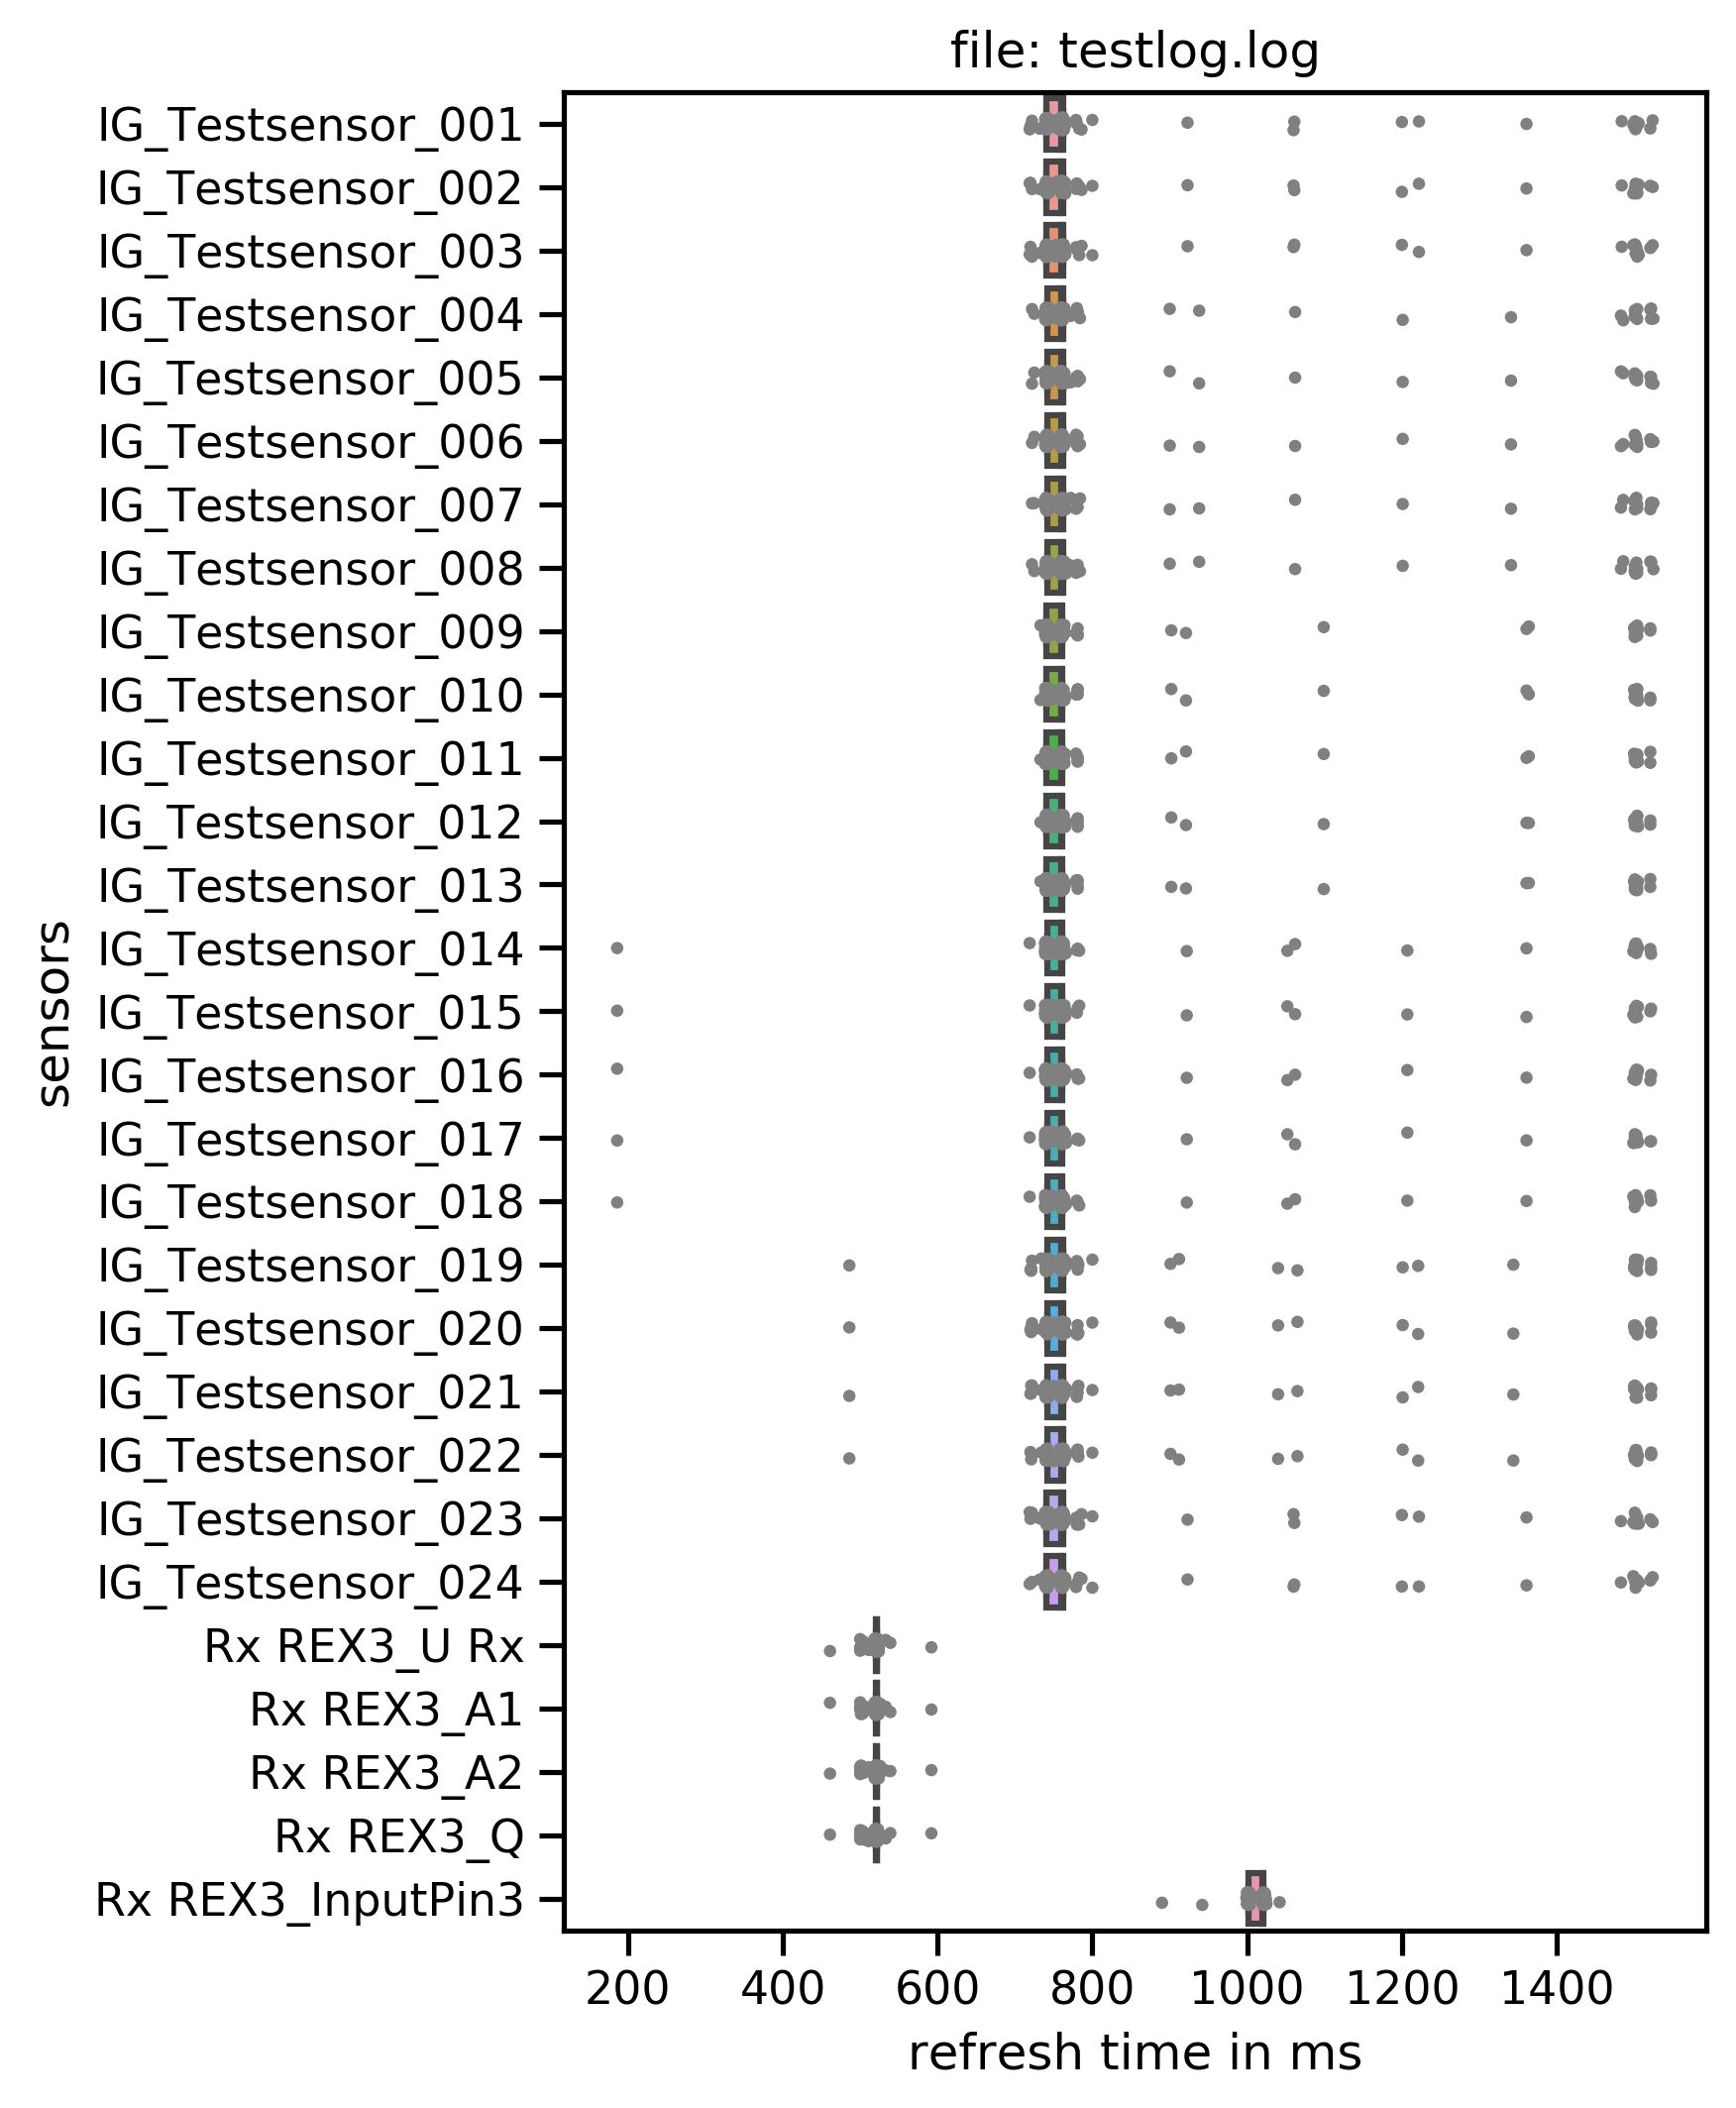

In [7]:
# plotting
sns.set_context("notebook")

size = (6, len(sensor_df.index) * 0.25)
resolution = 300

fig, ax = plt.subplots(figsize = size, dpi = resolution)

sns.boxplot(data = diff_df, x = "time_diff", y = "label", ax = ax, showfliers = False, whis = 0)
sns.stripplot(data = diff_df, x = "time_diff", y = "label", ax = ax, color = "gray", size = 3)

ax.set(xlabel = "refresh time in ms", ylabel = "sensors")
ax.set_title("file: " + logfile)
plt.tight_layout()

fig.savefig(os.path.join(logfile[:-4] + "_refresh_time_distribution.png"))